In [23]:
import pandas as pd
import numpy as np
import pytesseract
from torchmetrics.functional import char_error_rate, word_error_rate
from skimage.transform import rotate
from skimage.util import random_noise
import PIL
import cv2
from matplotlib import pyplot as plt
import re

In [2]:
# sudo pacman -Syu libvoikko hspell nuspell hunspell aspell
from sibigrapi2023.pipelines.processing.utils import accuracyByLevenshteinDistance, cleanText

In [3]:
labels = context.catalog.load("labels")

[06/09/23 17:59:25] INFO     Loading data from 'labels' (PartitionedDataSet)...                 ]8;id=831266;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=932315;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
express_expense = context.catalog.load("express_expense")

                    INFO     Loading data from 'express_expense' (PartitionedDataSet)...        ]8;id=795627;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=316601;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
l1 = labels['1000-receipt.txt']()

In [6]:
r1 = pytesseract.image_to_string(express_expense['1000-receipt.jpg']())

In [7]:
accuracyByLevenshteinDistance(r1, l1)

0.9498069498069498

In [8]:
import time
start = time.process_time()
# your code here    
print(time.process_time() - start)

0.00015907099999878938


In [9]:
print(cleanText(l1))

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 908O4
(562) 597-0906
Server: Francis Station: 3
Order #: 69923 dine In
Table: B11 Guests: 2
1 Coffee 3.00
2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1: 4.68
TOTAL: $56.58
5/26/2016 12:53:10 PM
THANK YOU!


In [10]:
print(cleanText(r1))

GAEEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(562) 597-0906
Server: Francis Station: 3
Order #: 69923 Dine In
Table: BI1 Guests: 2
1 Coffee 3.00
2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1: y.68
0TAL: $56.58
5/26/2016 12:53:10 pH
e
THANK You!


In [11]:
def generate_results(preprocess_image_func):
    results = list()
    for file_name, loader in express_expense.items():
        image = loader()
        image = preprocess_image_func(image)
        label = labels[file_name.replace('.jpg', '.txt')]()
        start = time.process_time()
        ocr_text = pytesseract.image_to_string(image)
        ocr_time = time.process_time() - start
        result = {'image_file': file_name,
                  #'ld': accuracyByLevenshteinDistance(ocr_text, label),
                  'wer': float(word_error_rate(preds=cleanText(ocr_text), target=cleanText(label))),
                  'cer': float(char_error_rate(preds=cleanText(ocr_text), target=cleanText(label))),
                  'br': 1 if ocr_text else 0,
                  'ba': int(ocr_text == label),
                  'run_time': ocr_time}
        results.append(result)
        df_results = pd.DataFrame(results)
        df_results['ba'] = df_results['cer'].le(0.05).astype(int)
    return df_results

def rotate5(image):
    return (rotate(np.array(image), 5, resize=True) * 255).astype(np.uint8)
def rotate10(image):
    return (rotate(np.array(image), 10, resize=True) * 255).astype(np.uint8)
def rotate15(image):
    return (rotate(np.array(image), 15, resize=True) * 255).astype(np.uint8)
def rotate20(image):
    return (rotate(np.array(image), 20, resize=True) * 255).astype(np.uint8)
def rotate_m5(image):
    return (rotate(np.array(image), -5, resize=True) * 255).astype(np.uint8)
def rotate_m10(image):
    return (rotate(np.array(image), -10, resize=True) * 255).astype(np.uint8)
def rotate_m15(image):
    return (rotate(np.array(image), -15, resize=True) * 255).astype(np.uint8)
def rotate_m20(image):
    return (rotate(np.array(image), -20, resize=True) * 255).astype(np.uint8)

def bright10(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=10)
def bright30(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=30)
def bright50(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=50)
def bright_m10(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=-10)
def bright_m30(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=-30)
def bright_m50(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1, beta=-50)

def contrast25(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1.25, beta=0)
def contrast50(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1.50, beta=0)
def contrast75(image):
    return cv2.convertScaleAbs(np.array(image), alpha=1.75, beta=0)
def contrast_m75(image):
    return cv2.convertScaleAbs(np.array(image), alpha=0.75, beta=0)
def contrast_m50(image):
    return cv2.convertScaleAbs(np.array(image), alpha=0.50, beta=0)
def contrast_m25(image):
    return cv2.convertScaleAbs(np.array(image), alpha=0.25, beta=0)

def random_noise05(image):
    return (random_noise(np.array(image), mode='gaussian', var=0.005) * 255).astype(np.uint8)
def random_noise10(image):
    return (random_noise(np.array(image), mode='gaussian', var=0.01) * 255).astype(np.uint8)
def random_noise15(image):
    return (random_noise(np.array(image), mode='gaussian', var=0.015) * 255).astype(np.uint8)

def pyr_blur2(image):
    return cv2.pyrDown(np.array(image))
def pyr_blur3(image):
    return cv2.pyrDown(cv2.pyrDown(np.array(image)))

def gaussian_blur3(image):
    return cv2.GaussianBlur(np.array(image), (3, 3), 0)
def gaussian_blur5(image):
    return cv2.GaussianBlur(np.array(image), (5, 5), 0)
def gaussian_blur7(image):
    return cv2.GaussianBlur(np.array(image), (7, 7), 0)

In [12]:
df = generate_results(lambda x: x)

In [13]:
df.to_csv("default_results_aggregated.csv")

In [14]:
df

,image_file,wer,cer,br,ba,run_time
0,1000-receipt.jpg,0.187500,0.050193,1,0,0.150055
1,1001-receipt.jpg,1.000000,1.000000,0,0,0.167272
2,1002-receipt.jpg,0.947368,0.799555,1,0,0.239049
3,1003-receipt.jpg,1.000000,1.000000,0,0,0.231048
4,1004-receipt.jpg,0.565217,0.174603,1,0,0.171575
...,...,...,...,...,...,...
186,1195-receipt.jpg,0.450704,0.322275,1,0,0.200740
187,1196-receipt.jpg,0.600000,0.304478,1,0,0.036446
188,1197-receipt.jpg,0.483333,0.172911,1,0,0.044204
189,1198-receipt.jpg,0.494253,0.206759,1,0,0.031139


In [15]:
df.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.549824,0.405603,0.973822,0.047120,0.167884
std,0.266240,0.285195,0.160084,0.212453,0.251513
min,0.045455,0.014778,0.000000,0.000000,0.017182
25%,0.341053,0.179164,1.000000,0.000000,0.059270
50%,0.520000,0.323782,1.000000,0.000000,0.174892
75%,0.771577,0.593891,1.000000,0.000000,0.208849
max,1.019231,1.000000,1.000000,1.000000,3.442488


## Rotation

In [12]:
r5 = generate_results(rotate5)

In [13]:
r5.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.785310,0.663828,0.853403,0.005236,0.568023
std,0.209633,0.275792,0.354633,0.072357,0.635577
min,0.148148,0.044304,0.000000,0.000000,0.144784
25%,0.654871,0.434181,1.000000,0.000000,0.349706
50%,0.824561,0.680965,1.000000,0.000000,0.553213
75%,0.971691,0.928105,1.000000,0.000000,0.622351
max,1.029851,1.000000,1.000000,1.000000,9.001328


In [22]:
r5.describe().loc[['mean', 'std'], :].apply(lambda x: round(x * 100, 2))

,wer,cer,br,ba,run_time
mean,78.53,66.38,85.34,0.52,56.80
std,20.96,27.58,35.46,7.24,63.56


In [18]:
r10 = generate_results(rotate10)

In [19]:
r10.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.974267,0.934865,0.481675,0.0,0.245647
std,0.063450,0.107913,0.500977,0.0,0.264757
min,0.352941,0.307692,0.000000,0.0,0.060701
25%,0.967204,0.903359,0.000000,0.0,0.176144
50%,1.000000,1.000000,0.000000,0.0,0.233787
75%,1.000000,1.000000,1.000000,0.0,0.259518
max,1.000000,1.000000,1.000000,0.0,3.795043


In [20]:
r15 = generate_results(rotate15)

In [21]:
r15.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.994711,0.983337,0.214660,0.0,0.246905
std,0.038685,0.056743,0.411665,0.0,0.266302
min,0.555556,0.487179,0.000000,0.0,0.065086
25%,1.000000,1.000000,0.000000,0.0,0.173150
50%,1.000000,1.000000,0.000000,0.0,0.236922
75%,1.000000,1.000000,0.000000,0.0,0.261024
max,1.000000,1.000000,1.000000,0.0,3.814489


In [22]:
r20 = generate_results(rotate20)

In [23]:
r20.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.997813,0.992545,0.141361,0.0,0.249330
std,0.027593,0.043569,0.349309,0.0,0.267308
min,0.619048,0.423077,0.000000,0.0,0.069493
25%,1.000000,1.000000,0.000000,0.0,0.170392
50%,1.000000,1.000000,0.000000,0.0,0.240386
75%,1.000000,1.000000,0.000000,0.0,0.263543
max,1.000000,1.000000,1.000000,0.0,3.822973


In [24]:
rm5 = generate_results(rotate_m5)

In [25]:
rm5.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.777732,0.655197,0.837696,0.010471,0.245770
std,0.226447,0.289018,0.369698,0.102059,0.266385
min,0.113636,0.034749,0.000000,0.000000,0.085213
25%,0.630306,0.413689,1.000000,0.000000,0.179643
50%,0.849057,0.690000,1.000000,0.000000,0.228777
75%,0.982759,0.929081,1.000000,0.000000,0.256764
max,1.134328,1.000000,1.000000,1.000000,3.828410


In [26]:
rm10 = generate_results(rotate_m10)

In [27]:
rm10.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.971317,0.929020,0.471204,0.0,0.247557
std,0.063936,0.125572,0.500482,0.0,0.270675
min,0.681818,0.396429,0.000000,0.0,0.073283
25%,0.982266,0.916310,0.000000,0.0,0.177099
50%,1.000000,1.000000,0.000000,0.0,0.233784
75%,1.000000,1.000000,1.000000,0.0,0.259022
max,1.000000,1.000000,1.000000,0.0,3.880389


In [28]:
rm15 = generate_results(rotate_m15)

In [29]:
rm15.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.995521,0.984396,0.178010,0.0,0.248495
std,0.023095,0.045944,0.383527,0.0,0.269671
min,0.714286,0.641330,0.000000,0.0,0.068650
25%,1.000000,1.000000,0.000000,0.0,0.174094
50%,1.000000,1.000000,0.000000,0.0,0.235899
75%,1.000000,1.000000,0.000000,0.0,0.262463
max,1.000000,1.000000,1.000000,0.0,3.863929


In [30]:
rm20 = generate_results(rotate_m20)

In [31]:
rm20.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.999116,0.996767,0.068063,0.0,0.251582
std,0.012216,0.020415,0.252516,0.0,0.275055
min,0.831169,0.745843,0.000000,0.0,0.067976
25%,1.000000,1.000000,0.000000,0.0,0.174285
50%,1.000000,1.000000,0.000000,0.0,0.240191
75%,1.000000,1.000000,0.000000,0.0,0.265586
max,1.000000,1.000000,1.000000,0.0,3.934768


## Brightness

In [32]:
b10 = generate_results(bright10)

In [33]:
b10.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.550507,0.406518,0.973822,0.052356,0.168535
std,0.265950,0.285293,0.160084,0.223329,0.252597
min,0.068182,0.014778,0.000000,0.000000,0.017529
25%,0.341784,0.179164,1.000000,0.000000,0.056073
50%,0.521739,0.325000,1.000000,0.000000,0.177270
75%,0.771577,0.595682,1.000000,0.000000,0.209352
max,1.019231,1.000000,1.000000,1.000000,3.456153


In [34]:
b30 = generate_results(bright30)

In [35]:
b30.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.552093,0.408991,0.973822,0.052356,0.168766
std,0.266847,0.287083,0.160084,0.223329,0.257324
min,0.020408,0.003367,0.000000,0.000000,0.017211
25%,0.340732,0.184015,1.000000,0.000000,0.059004
50%,0.528571,0.325000,1.000000,0.000000,0.177315
75%,0.782782,0.600480,1.000000,0.000000,0.208473
max,1.019231,1.000000,1.000000,1.000000,3.524047


In [36]:
b50 = generate_results(bright50)

In [37]:
b50.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.558445,0.415922,0.968586,0.041885,0.159839
std,0.265650,0.288367,0.174891,0.200852,0.246454
min,0.022727,0.003367,0.000000,0.000000,0.015598
25%,0.344522,0.192688,1.000000,0.000000,0.056872
50%,0.531915,0.318078,1.000000,0.000000,0.156205
75%,0.798599,0.629615,1.000000,0.000000,0.204203
max,1.019231,1.000000,1.000000,1.000000,3.365231


In [38]:
bm10 = generate_results(bright_m10)

In [39]:
bm10.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.546672,0.402384,0.979058,0.047120,0.171224
std,0.265656,0.285613,0.143568,0.212453,0.259505
min,0.045455,0.014778,0.000000,0.000000,0.017637
25%,0.334706,0.179164,1.000000,0.000000,0.059020
50%,0.521739,0.318907,1.000000,0.000000,0.178755
75%,0.746585,0.594770,1.000000,0.000000,0.211372
max,1.096154,1.000000,1.000000,1.000000,3.557335


In [40]:
bm30 = generate_results(bright_m30)

In [41]:
bm30.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.541365,0.396523,0.973822,0.047120,0.171606
std,0.265515,0.285179,0.160084,0.212453,0.266529
min,0.022727,0.003367,0.000000,0.000000,0.017332
25%,0.352471,0.165913,1.000000,0.000000,0.059083
50%,0.494253,0.327766,1.000000,0.000000,0.178274
75%,0.738290,0.585287,1.000000,0.000000,0.211154
max,1.000000,1.000000,1.000000,1.000000,3.659160


In [42]:
bm50 = generate_results(bright_m50)

In [43]:
bm50.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.539984,0.397389,0.968586,0.057592,0.170282
std,0.266722,0.277767,0.174891,0.233582,0.261413
min,0.022727,0.003367,0.000000,0.000000,0.017317
25%,0.335681,0.186437,1.000000,0.000000,0.059524
50%,0.491228,0.326347,1.000000,0.000000,0.178897
75%,0.748297,0.598099,1.000000,0.000000,0.210371
max,1.293103,1.000000,1.000000,1.000000,3.587595


## Contrast

In [45]:
c25 = generate_results(contrast25)

In [46]:
c25.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.561006,0.420105,0.968586,0.047120,0.181385
std,0.266263,0.291121,0.174891,0.212453,0.293510
min,0.040816,0.003367,0.000000,0.000000,0.015740
25%,0.344966,0.185694,1.000000,0.000000,0.061087
50%,0.532258,0.322500,1.000000,0.000000,0.175545
75%,0.794872,0.674190,1.000000,0.000000,0.230040
max,1.076923,1.000000,1.000000,1.000000,4.008014


In [47]:
c50 = generate_results(contrast50)

In [48]:
c50.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.606657,0.453827,0.931937,0.026178,0.131953
std,0.265166,0.293616,0.252516,0.160084,0.180771
min,0.044118,0.014286,0.000000,0.000000,0.009589
25%,0.399828,0.212414,1.000000,0.000000,0.057278
50%,0.561644,0.397959,1.000000,0.000000,0.108131
75%,0.838274,0.671860,1.000000,0.000000,0.177829
max,1.057692,1.000000,1.000000,1.000000,2.371055


In [49]:
c75 = generate_results(contrast75)

In [50]:
c75.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.00000,191.000000,191.000000
mean,0.646836,0.495031,0.91623,0.020942,0.103216
std,0.264473,0.305591,0.27777,0.143568,0.148432
min,0.092593,0.018987,0.00000,0.000000,0.008180
25%,0.430662,0.241840,1.00000,0.000000,0.046470
50%,0.632075,0.427208,1.00000,0.000000,0.087271
75%,0.911252,0.788262,1.00000,0.000000,0.133672
max,1.090909,1.000000,1.00000,1.000000,1.965879


In [ ]:
cm75 = generate_results(contrast_m75)

In [52]:
cm75.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.555257,0.410720,0.968586,0.041885,0.228489
std,0.268935,0.289939,0.174891,0.200852,0.390841
min,0.068182,0.017241,0.000000,0.000000,0.021555
25%,0.334384,0.180870,1.000000,0.000000,0.072644
50%,0.523810,0.323782,1.000000,0.000000,0.233911
75%,0.782292,0.637119,1.000000,0.000000,0.285853
max,1.076923,1.000000,1.000000,1.000000,5.380720


In [53]:
cm50 = generate_results(contrast_m50)

In [54]:
cm50.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.553224,0.407632,0.979058,0.047120,0.235331
std,0.264097,0.282646,0.143568,0.212453,0.407626
min,0.022727,0.010949,0.000000,0.000000,0.020842
25%,0.342105,0.187153,1.000000,0.000000,0.076401
50%,0.515152,0.321229,1.000000,0.000000,0.243845
75%,0.793866,0.599298,1.000000,0.000000,0.298794
max,1.057692,1.000000,1.000000,1.000000,5.611360


In [55]:
cm25 = generate_results(contrast_m25)

In [56]:
cm25.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.552095,0.410293,0.973822,0.047120,0.200493
std,0.266984,0.288339,0.160084,0.212453,0.345725
min,0.045455,0.014599,0.000000,0.000000,0.019076
25%,0.340588,0.170450,1.000000,0.000000,0.068475
50%,0.514286,0.324455,1.000000,0.000000,0.204953
75%,0.776772,0.588768,1.000000,0.000000,0.247692
max,1.038462,1.000000,1.000000,1.000000,4.762670


## Noise

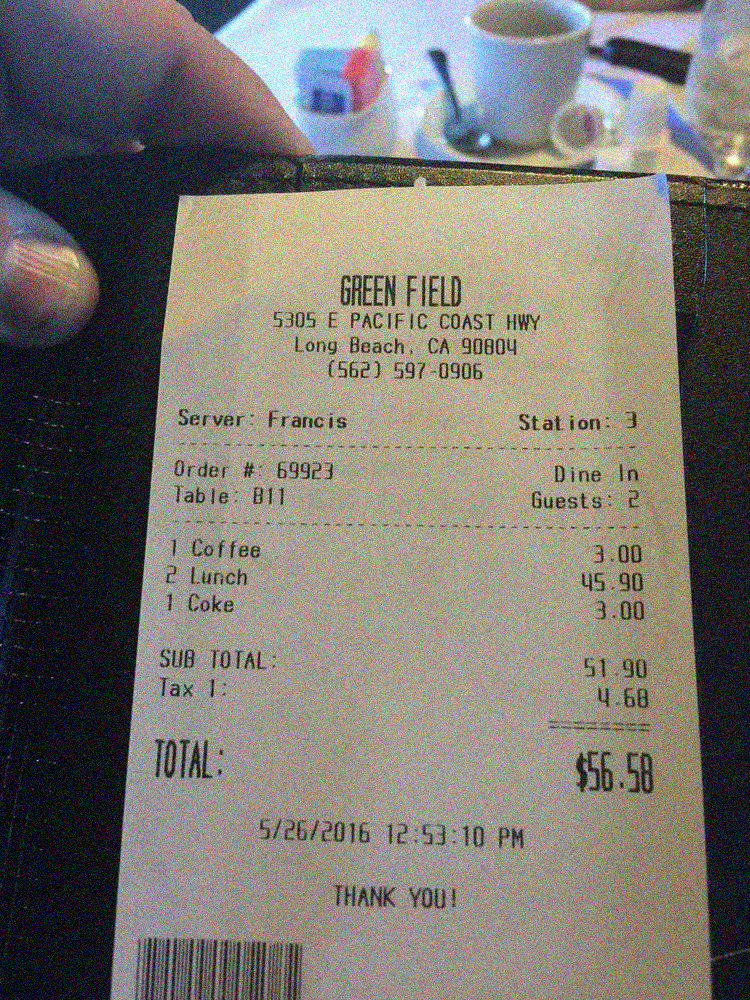

In [24]:
PIL.Image.fromarray(random_noise1(express_expense['1000-receipt.jpg']()))

In [25]:
sp1 = generate_results(random_noise1)

In [26]:
sp1.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.699198,0.587380,0.900524,0.020942,0.103146
std,0.263195,0.307769,0.300087,0.143568,0.144152
min,0.045455,0.006734,0.000000,0.000000,0.009992
25%,0.500000,0.303049,1.000000,0.000000,0.038479
50%,0.724138,0.589912,1.000000,0.000000,0.111263
75%,0.947632,0.888293,1.000000,0.000000,0.114036
max,1.000000,1.000000,1.000000,1.000000,1.890259


In [21]:
sp3 = generate_results(random_noise3)

In [22]:
sp3.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.979703,0.962439,0.214660,0.0,0.106448
std,0.068224,0.107275,0.411665,0.0,0.148727
min,0.448980,0.420875,0.000000,0.0,0.010942
25%,1.000000,1.000000,0.000000,0.0,0.035030
50%,1.000000,1.000000,0.000000,0.0,0.112207
75%,1.000000,1.000000,0.000000,0.0,0.116225
max,1.000000,1.000000,1.000000,0.0,1.907707


In [72]:
sp5 = generate_results(salt_pepper5)

In [73]:
sp5.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.929830,0.805982,0.617801,0.0,0.230389
std,0.113074,0.220080,0.487202,0.0,0.355670
min,0.250000,0.078571,0.000000,0.0,0.023153
25%,0.885431,0.627448,0.000000,0.0,0.078474
50%,1.000000,0.893035,1.000000,0.0,0.245746
75%,1.000000,1.000000,1.000000,0.0,0.277523
max,1.070175,1.000000,1.000000,0.0,4.907647


## Blur

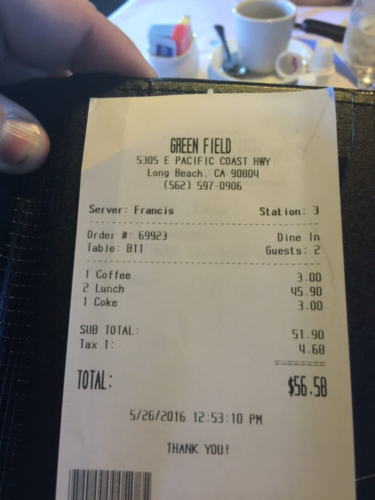

In [74]:
PIL.Image.fromarray(pyr_blur2(express_expense['1000-receipt.jpg']()))

In [63]:
pb2 = generate_results(pyr_blur2)

In [64]:
pb2.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.834979,0.746650,0.691099,0.005236,0.068150
std,0.222396,0.293196,0.463254,0.072357,0.075413
min,0.129032,0.028571,0.000000,0.000000,0.009363
25%,0.720950,0.541914,0.000000,0.000000,0.032748
50%,0.948276,0.871345,1.000000,0.000000,0.071836
75%,1.000000,1.000000,1.000000,0.000000,0.084372
max,1.000000,1.000000,1.000000,1.000000,1.018022


In [65]:
pb3 = generate_results(pyr_blur3)

In [66]:
pb3.describe()

,wer,cer,br,ba,run_time
count,191.000000,191.000000,191.000000,191.0,191.000000
mean,0.987983,0.979071,0.157068,0.0,0.028715
std,0.073957,0.097946,0.364821,0.0,0.022161
min,0.264000,0.121372,0.000000,0.0,0.005726
25%,1.000000,1.000000,0.000000,0.0,0.015403
50%,1.000000,1.000000,0.000000,0.0,0.027569
75%,1.000000,1.000000,0.000000,0.0,0.037470
max,1.000000,1.000000,1.000000,0.0,0.278995
